In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Read training/test data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: Each column in the array(s) epresents a single datapoint.

In [2]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    labels = []
    
    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')
            
            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)
            
            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        # convert labels list to array
        Y = np.array(labels, dtype = dtype_y, ndmin = 2)
        
        return X.transpose(), Y

# 1) Linear Regression 

### Helper Functions 

In [3]:
# k = frequency increment
# d = function depth
# given input datapoint 'x_sample', 
# returns transformed version of the intput datapoint as a numpy array
def get_feature_vector(x_sample, k, d):
    
    # stored transformed values in a list
    trans_feat_list = []
    
    # append 1 and value of 'x_sample' to the list
    trans_feat_list.append(float(1))
    trans_feat_list.append(float(x_sample))
    
    # remaining transformations will be based on 'k' and 'd'
    for i in range(1, d+1):
        val1 = ((np.sin(i*k*x_sample))**(i*k))*np.cos(x_sample)
        val2 = ((np.cos(i*k*x_sample))**(i*k))*np.sin(x_sample)
        trans_feat_list.append(val1)
        trans_feat_list.append(val2)
    
    # convert list into array
    x_sample_trans = np.array(trans_feat_list, dtype = float, ndmin = 2).transpose()

    # return transformed features
    return x_sample_trans


# calculates sample squared error
def get_sample_squared_error(y_sample, y_pred):
    
    # calculate and return squared error
    return np.square(y_sample - y_pred)


# get average squared error for an entire test dataset
def get_avg_squared_error(Y_pred, Y_test):

    sum_of_sq_err = np.sum(np.square(Y_pred - Y_test), axis = 1)
    
    # return average over number of samples
    return sum_of_sq_err[0]/Y_pred.shape[1]


# get's prediction value for a sample
def get_prediction_value_lr(x_sample, model_params, k, d):
    
    x_sample_trans = get_feature_vector(x_sample, k, d)
    y_pred = np.dot(model_params, x_sample_trans)

    # return prediction value as a scalar
    return y_pred[0, 0]
    

## 1 a) Model Training & Prediction

In [4]:
# returns predicted values for a given test data
def get_predictions_lr(X, model_params, k, d):
    
    # save number of test samples
    n_feat, n_samples = X.shape
    
    # initialize list to store prediction values
    predictions = []
    
    for i in range(n_samples):
        y_pred = get_prediction_value_lr(X[:,i][0], model_params, k, d)
        predictions.append(y_pred)

    Y_pred = np.array(predictions, dtype = float, ndmin = 2)
        
    return Y_pred


# trains a linear regression model 
def train_model_lr(X_train, Y_train, epochs, alpha, k, d):
    
    # get number of training samples
    n_feat, n_samples = X_train.shape
    
    # get output dimension
    n_out, __ = Y_train.shape
    
    # initialize parameter vector
    model_params = np.random.uniform(-0.01, 0.01, size = (n_out, (2*d)+2))
    
    # initialize lists to store training error per epoch
    training_err_over_epochs = []
    
    # initialize list to store net change in parameter values
    change_model_params = []
    
    # do this per epoch
    for i in range(epochs): 
        
        # initialize gradient vector for each epoch
        gradient_vec = np.zeros((n_out, (2*d)+2), dtype = float)
        
        for j in range(n_samples):
            
            # pick a sample 
            x_sample = X_train[:,j]
            y_sample = Y_train[:,j]
            
            # get prediction value and adjust weights
            y_pred = get_prediction_value_lr(x_sample[0], model_params, k, d)
            x_sample = get_feature_vector(x_sample[0], k, d)
            
            # sum gradients over all training samples
            gradient_vec = gradient_vec + (y_pred - y_sample[0])*(x_sample.transpose())
        
        # adjust parameter values using batch gradient descent 
        updated_params = model_params - (alpha*gradient_vec)
        
        # get the net change in parameters
        net_change = np.sum(np.abs(model_params - updated_params))
        change_model_params.append(net_change)
            
        # set updated parameters as new parameters  
        model_params = updated_params.copy()
        
        # get preediction and error on training data
        Y_train_pred = get_predictions_lr(X_train, model_params, k, d)
        training_err_over_epochs.append(get_avg_squared_error(Y_train_pred, Y_train))    
        
    # return final parameter vector
    return model_params, training_err_over_epochs, change_model_params

### Helper functions for ploting results

In [5]:
# given model parameters and training data, plots function
def plot_function_lr(model_params, X_train, Y_train, k, d, n_values):
    
    # create domain for plotting function
    X_range = np.linspace(np.amin(X_train), np.amax(X_train)+0.1, n_values)
    
    # convert array to 1D
    X_train = X_train.squeeze()
    Y_train = Y_train.squeeze()
    
    # get function values for x domain values
    Y_pred = get_predictions_lr(X_range.reshape(1, n_values), model_params, k, d)
    Y_pred = Y_pred.squeeze()
    
    # plot function values VS actual values for training data
    fig = plt.figure(figsize = (10, 6))
    plt.plot(X_range, Y_pred, color = 'blue')
    plt.scatter(X_train, Y_train, color = 'orange')
    
    # add title, labels and legend
    plt.legend(['Function Value', 'Training Data'], loc = 2)
    title_str = f'Regression model for d = {d} and k = {k}'
    plt.title(title_str, fontdict = {'fontsize': 15})
    plt.xlabel('x', fontdict = {'fontsize': 12})
    plt.ylabel('y', fontdict = {'fontsize': 12})
    plt.grid()

    
# plots training vs test error
def plot_training_vs_test_error_lr(training_err, test_err, title_str, xlab, ylab):
    
    # plot training VS test error for given function depth(d)
    fig = plt.figure(figsize = (10, 6))
    plt.plot(training_err, color = 'orange')
    plt.plot(test_err, color = 'red')
    
    # add title, labels and legend
    plt.title(title_str, fontdict = {'fontsize': 15})
    plt.legend(['Training Error', 'Test Error'])
    plt.xlabel(xlab, fontdict = {'fontsize': 12})
    plt.ylabel(ylab, fontdict = {'fontsize': 12})
    plt.grid()
    
    
def plot_y_pred_vs_y_test(X_test, Y_test, Y_pred, d):
    
    # convert arrays to 1D
    X_test_p = X_test.squeeze()
    Y_test_p = Y_test.squeeze()
    Y_pred_p = Y_pred.squeeze()

    # plot function values VS actual values for training data
    fig = plt.figure(figsize = (10, 6))
    plt.scatter(X_test_p, Y_pred_p, color = 'blue')
    plt.scatter(X_test_p, Y_test_p, color = 'orange')

    # add title, labels and legend
    plt.legend(['Prediction Value', 'Actual Value'], loc = 2)
    title_str = f'Prediction for test data using d = {d}'
    plt.title(title_str, fontdict = {'fontsize': 15})
    plt.xlabel('x', fontdict = {'fontsize': 12})
    plt.ylabel('y', fontdict = {'fontsize': 12})
    plt.grid()

### Provide training filename, alpha, number of epochs and function depth(d)
1) fname_train: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:<br>
((x1, x2, .....xn), y) <br>

## 1 b) Plotting resulting function for d = 0 to 6

#### Model Training

In [6]:
# provide filename & get data
fname_train = "reg_train.txt"
X_train, Y_train = get_X_Y_arrays(fname_train, float, float)

# initialize hyperparameters
epochs = 2000
k = 8
alpha = 0.001
d_max = 6

# initialize list to store model parameters, training error and test error for various function depths
model_params_list = []           # stores parameters for different function depth
training_err_list = []           # stores training error throughout epochs per function depth
change_model_params_list = []    # stores net change in model parameters over epochs

# train model and get parameters and error for d = 0 to 6
for i in range(0, d_max + 1):
    model_params, training_err, change_model_params = train_model_lr(X_train, Y_train, epochs, alpha, k, i)
    model_params_list.append(model_params)
    training_err_list.append(training_err)
    change_model_params_list.append(change_model_params)
    

### Model Plotting at various function depths

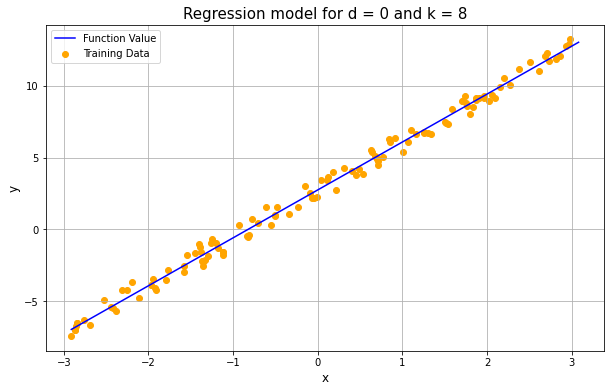

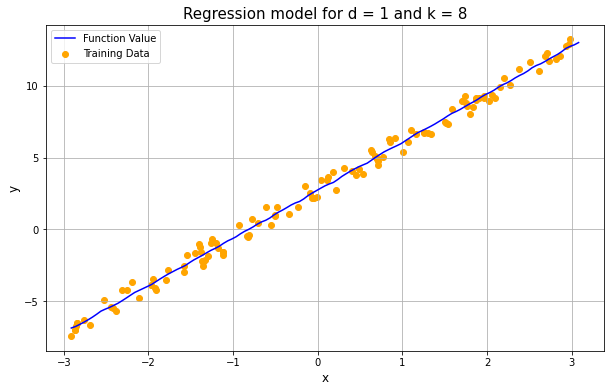

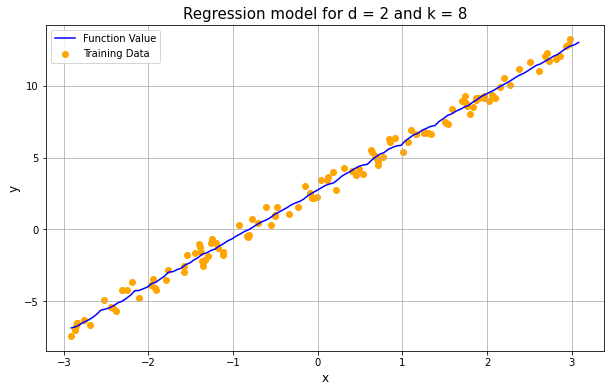

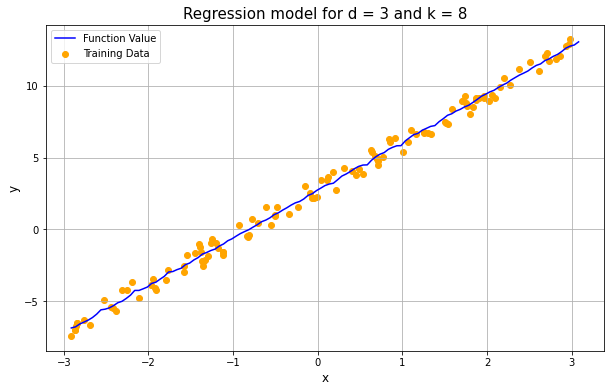

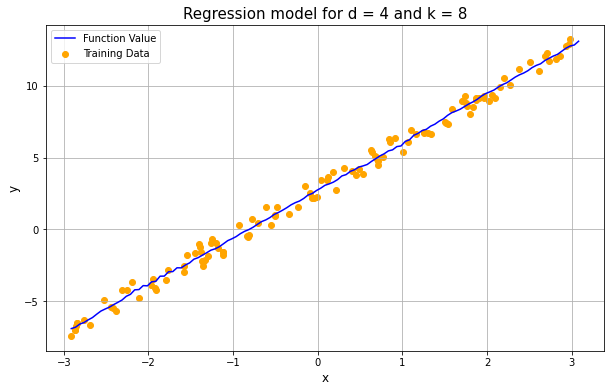

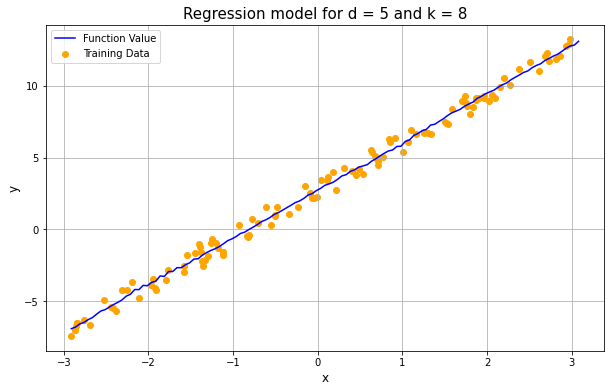

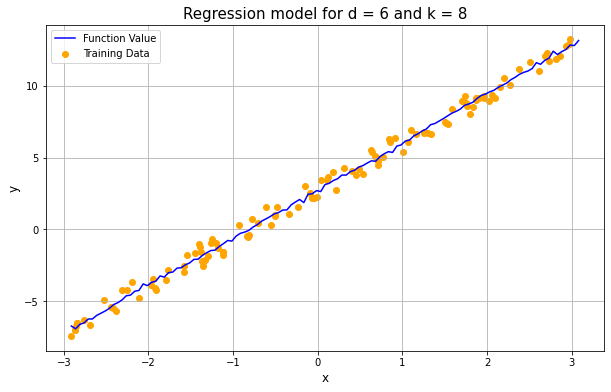

In [7]:
n_samples = X_train.shape[1]
for i in range(0, 7):
    plot_function_lr(model_params_list[i], X_train, Y_train, k, i, n_samples)

### Plot change in model parameters and error 

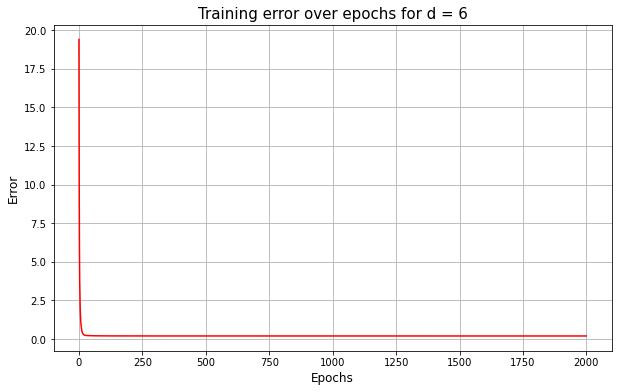

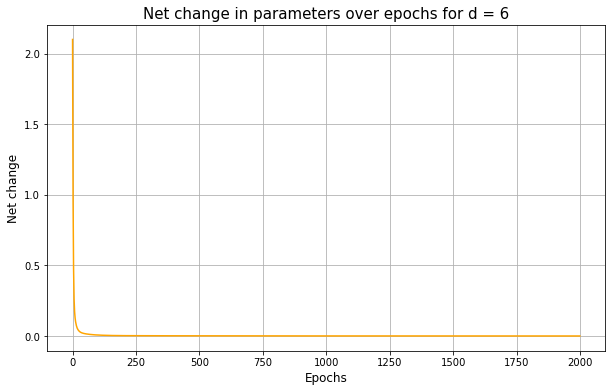

In [8]:
# pick a unctional depth
d = 6

# plot training accuracy over epochs
fig1 = plt.figure(figsize = (10,6))
plt.plot(training_err_list[d], color = 'red')
plt.xlabel('Epochs', fontdict = {'fontsize': 12})
plt.ylabel('Error', fontdict = {'fontsize': 12})
plt.title(f'Training error over epochs for d = {d}', fontdict = {'fontsize': 15})
plt.grid()

# plot change in paramteter values over epochs
fig1 = plt.figure(figsize = (10,6))
plt.plot(change_model_params_list[d], color = 'orange')
plt.xlabel('Epochs', fontdict = {'fontsize': 12})
plt.ylabel('Net change', fontdict = {'fontsize': 12})
plt.title(f'Net change in parameters over epochs for d = {d}', fontdict = {'fontsize': 15})
plt.grid()

## 1 c) Model evaluation at various function depths for overfitting

#### Provide test filename:
fname_test: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:<br>
((x1, x2, .....xn), y) <br>


In [9]:
# provide filename & get data
fname_test = "reg_test.txt"
X_test, Y_test = get_X_Y_arrays(fname_test, float, float)

# get error for test data
test_err_list = []
test_pred_list = []

for i in range(0, d_max+1):
    Y_pred = get_predictions_lr(X_test, model_params_list[i], k, i)
    test_err_list.append(get_avg_squared_error(Y_pred, Y_test))
    test_pred_list.append(Y_pred)
    
# get training error for last epochs
training_err_last_epoch = []
for i in range(0, d_max+1):
    Y_pred_train = get_predictions_lr(X_train, model_params_list[i], k, i)
    training_err_last_epoch.append(get_avg_squared_error(Y_pred_train, Y_train))

### Plot Y_pred vs Y_test for all models

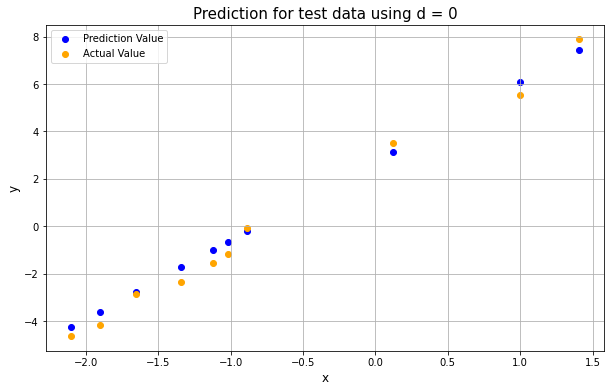

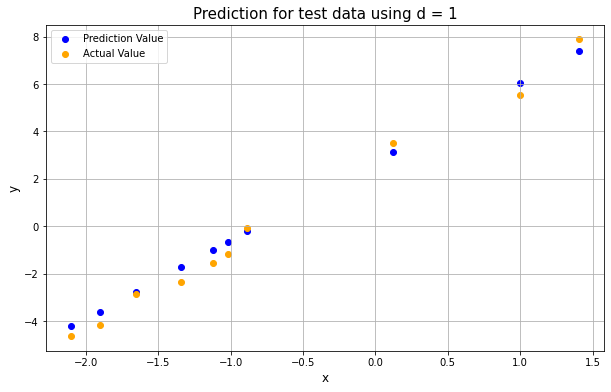

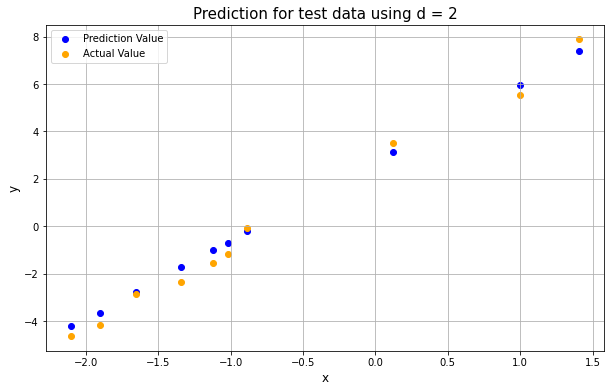

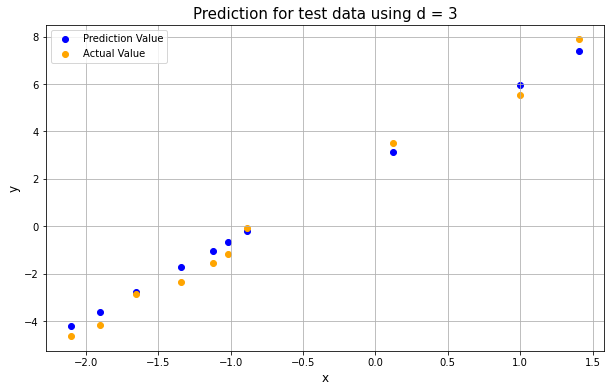

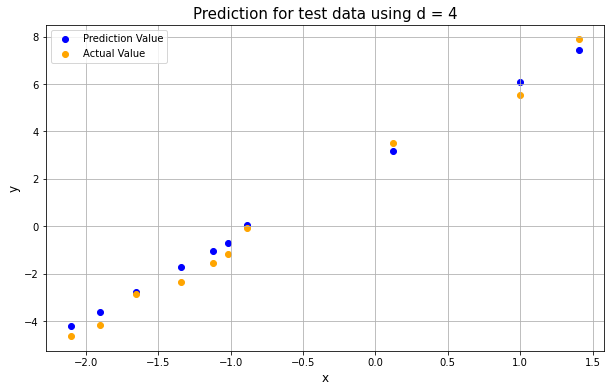

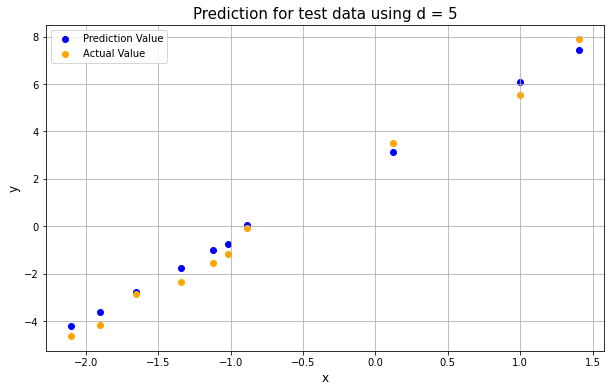

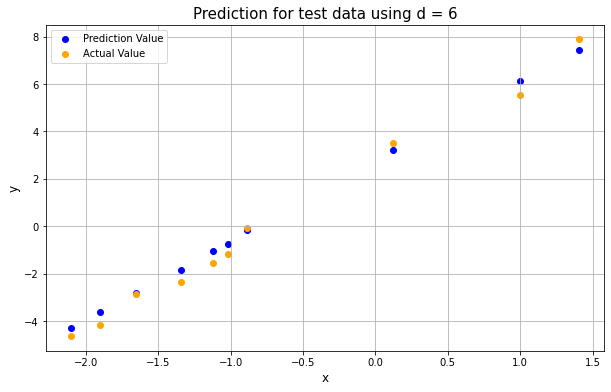

In [10]:
for i in range(0, d_max+1):
    plot_y_pred_vs_y_test(X_test, Y_test, test_pred_list[i], i)

### Plot training VS test error for all models

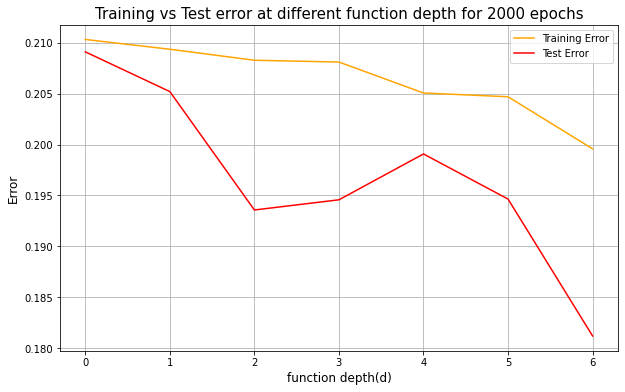

In [11]:
title = f'Training vs Test error at different function depth for {epochs} epochs'
plot_training_vs_test_error_lr(training_err_last_epoch, test_err_list,
                             title, 'function depth(d)', 'Error')

In [12]:
# print error info
for i in range(0, d_max+1):
    print(f'For d = {i}:')
    print(f'Training error: {training_err_last_epoch[i]:0.4f}')
    print(f'Test error: {test_err_list[i]:0.4f}\n')

For d = 0:
Training error: 0.2103
Test error: 0.2091

For d = 1:
Training error: 0.2094
Test error: 0.2052

For d = 2:
Training error: 0.2083
Test error: 0.1936

For d = 3:
Training error: 0.2081
Test error: 0.1946

For d = 4:
Training error: 0.2051
Test error: 0.1991

For d = 5:
Training error: 0.2047
Test error: 0.1946

For d = 6:
Training error: 0.1996
Test error: 0.1812



In [13]:
# get index of model with lowest test error
idx_lowest_err = test_err_list.index(min(test_err_list))
print(f'Model with d = {idx_lowest_err} has the lowest test error of {min(test_err_list):0.4f}.')

Model with d = 6 has the lowest test error of 0.1812.


### Plot training & test datapoints

Text(0, 0.5, 'y')

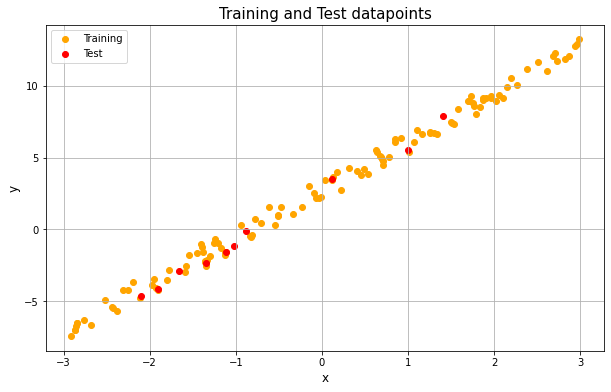

In [14]:
plt.figure(figsize = (10, 6))
plt.scatter(X_train, Y_train, color = 'orange')
plt.scatter(X_test, Y_test, color = 'red')
plt.grid()
plt.legend(['Training', 'Test'])
plt.title('Training and Test datapoints', fontdict = {'fontsize': 15})
plt.xlabel('x', fontdict = {'fontsize': 12})
plt.ylabel('y', fontdict = {'fontsize': 12})

### 1 c) Conclusion: 

For d = 0:<br>
Training error: 0.2103<br>
Test error: 0.2091<br>

For d = 1:<br>
Training error: 0.2094<br>
Test error: 0.2052<br>

For d = 2:<br>
Training error: 0.2083<br>
Test error: 0.1936<br>

For d = 3:<br>
Training error: 0.2081<br>
Test error: 0.1946<br>

For d = 4:<br>
Training error: 0.2051<br>
Test error: 0.1991<br>

For d = 5:<br>
Training error: 0.2047<br>
Test error: 0.1946<br>

For d = 6:<br>
Training error: 0.1996<br>
Test error: 0.1812<br>


Although the test error was expected to increase with an increase in function depth - which suggests overfitting - the test error was also found to decrease with an increase in function depth (like the training error). To analyze these results the training datapoints(orange) were plotted with the test datapoints(red) in figure titled 'Training and Test datapoints'. The figure shows that all test datapoints are close to the model function and consistent with the training dataset.<br>

The test dataset was not used during the training process; therefore, a possible explanation for the test error being lower than the training error is that the test data is pretty consistent ith the training data and may not have had a lot of noise in comparsin to the training dataset. <br>

Since model with d = 6 has the lowest test error, it would be the best prediction function in this case. However, in practise it would better to use a simpler model if the different in performce is not too significant.